# Makemore Part 4 - Becoming a Backprop Ninja

This notebook is a summary of Andrej Karpathy's [Building makemore Part 4: Becoming a Backprop Ninja](https://youtu.be/q8SA3rM6ckI?si=wF75sMbXpgDd6U1y) as part of the Neural Networks: Zero to Hero series.

All the major machine learning libraries/frameworks have an autograd engine that automatically computes gradients using backpropagation. However, backpropagation is a leaky abstraction - we need to understand what is going on under the hood to use it effectively and debug problems.

Previously, we implemented `micrograd` which was a scalar-level autograd engine, but we would now like to extend that to the level of tensors. In this notebook, we try to backpropagate by hand our network from part 3.

Fun fact: In the past, everyone wrote backward passes for their network by hand, instead of using autograd engines.

In [1]:
# ---------- SETUP CODE ----------

In [2]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# set up dataset
# !wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
    X, Y = [], []
  
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
    # dt is our calculated gradient, t is pytorch's gradient
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | shape_match: {str(dt.shape == t.shape):6s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [7]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

4137


In [8]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [9]:
# ---------- SETUP CODE END ----------

## Exercise 1

In [10]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
    p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
    t.retain_grad()
loss.backward()
loss

tensor(3.3353, grad_fn=<NegBackward0>)

In [11]:
# Exercise 1: backprop through the whole thing manually, 
# backpropagating through exactly all of the variables 
# as they are defined in the forward pass above, one by one

# -----------------
# YOUR CODE HERE :)
# -----------------
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n),Yb] = -1.0/n

dprobs = (1.0 / probs) * dlogprobs

dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)

dcounts = counts_sum_inv * dprobs

dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv

dcounts += torch.ones_like(counts) * dcounts_sum

dnorm_logits = norm_logits.exp() * dcounts

dlogit_maxes = -dnorm_logits.sum(1, keepdim=True)

dlogits = dnorm_logits.clone()
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes

dh = dlogits @ W2.T
dW2 = h.T @ dlogits
# be careful of dimension of broadcasting
db2 = dlogits.sum(0)

dhpreact = dh * (1 - h**2)

dbngain = (dhpreact * bnraw).sum(0, keepdim=True)
dbnraw = dhpreact * bngain
dbnbias = dhpreact.sum(0, keepdim=True)

dbndiff = dbnraw * bnvar_inv
dbnvar_inv = (dbnraw * bndiff).sum(0, keepdim=True)

dbnvar = -0.5 * (bnvar + 1e-5) ** -1.5 * dbnvar_inv

dbndiff2 = 1/(n-1) * torch.ones_like(bndiff2) * dbnvar
dbndiff += 2 * dbndiff2 * bndiff

dbnmeani = -dbndiff.sum(0, keepdim=True)
dhprebn = dbndiff.clone()

dhprebn += 1/n * torch.ones_like(hprebn) * dbnmeani

dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)

demb = dembcat.view(emb.shape)

# emb = C[Xb]
# Xb is (32,3), each element being a number that is used to index into C.
# emb is (32,3,10), where for each element in Xb, we have the embedding
# For indices i,j, demb[i,j] represents the gradients for each element of the embedding of the character X[i,j]
# Need to accumulate gradients because rows will be reused
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]

cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | shape_match: True   | exact: True  | approximate: True  | maxdiff: 0.0
probs           | shape_match: True   | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | shape_match: True   | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | shape_match: True   | exact: True  | approximate: True  | maxdiff: 0.0
counts          | shape_match: True   | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | shape_match: True   | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | shape_match: True   | exact: True  | approximate: True  | maxdiff: 0.0
logits          | shape_match: True   | exact: True  | approximate: True  | maxdiff: 0.0
h               | shape_match: True   | exact: True  | approximate: True  | maxdiff: 0.0
W2              | shape_match: True   | exact: True  | approximate: True  | maxdiff: 0.0
b2              | shape_match: True   | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | sha

Tips:
1. When you have a sum in the forward pass, that turns into a broadcasting in the backward pass. When you have a broadcasting in the forward pass, that indicates variable re-use so in the backward pass, it becomes a sum.
2. Deriving the backward pass of a matrix multiplication:
  - Dimensions need to work out, e.g. dx (derivative of loss w.r.t. x) must have same dimension as x
  - Backward pass of a matrix multiplication is also a matrix multiplication, so transpose as necessary to get the required dimension
3. Indexing:
  - We have `emb = C[Xb]` in the forward pass
  - `Xb` is (32,3), each element being a number that is used to index into `C`
  - `emb` is (32,3,10), where for each element in `Xb`, we have the 10-dimensional embedding
  - For indices `i`,`j`, `demb[i,j]` represents the gradients for each element of the embedding of the character corresponding to`X[i,j]`
  - Need to accumulate gradients because rows will be reused

## Exercise 2

In [12]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())


3.335263729095459 diff: 2.384185791015625e-07


In [13]:
# backward pass

# -----------------
# YOUR CODE HERE :)
dlogits = F.softmax(logits, dim=1) - F.one_hot(Yb, num_classes=27)
dlogits *= 1/n
# dprobs = torch.zeros_like(logprobs)
# dprobs[range(n),Yb] = 1.0 / (probs * n)
# dnorm_logits = torch.full(norm_logits.shape, norm_logits.shape[0] - 1) * dprobs
# -----------------
cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9


logits          | shape_match: True   | exact: False | approximate: True  | maxdiff: 6.984919309616089e-09


### Interpreting `dlogits`

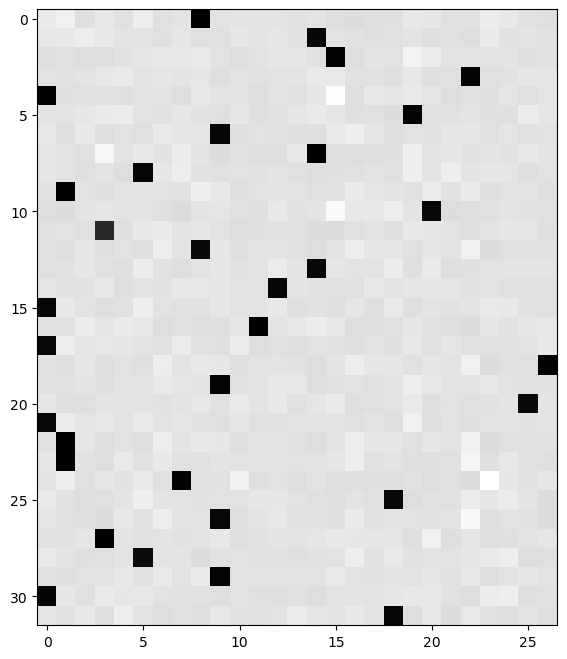

In [14]:
plt.figure(figsize=(8,8))
plt.imshow(dlogits.detach(), cmap='gray')

In [15]:
F.softmax(logits, 1)[0]

tensor([0.0681, 0.0923, 0.0189, 0.0520, 0.0209, 0.0827, 0.0228, 0.0354, 0.0179,
        0.0308, 0.0369, 0.0354, 0.0361, 0.0288, 0.0352, 0.0135, 0.0089, 0.0194,
        0.0166, 0.0556, 0.0475, 0.0202, 0.0250, 0.0770, 0.0572, 0.0253, 0.0199],
       grad_fn=<SelectBackward0>)

In [16]:
dlogits[0] * n # multiply n to cancel out the effect of averaging over examples, for interpretability

tensor([ 0.0681,  0.0923,  0.0189,  0.0520,  0.0209,  0.0827,  0.0228,  0.0354,
        -0.9821,  0.0308,  0.0369,  0.0354,  0.0361,  0.0288,  0.0352,  0.0135,
         0.0089,  0.0194,  0.0166,  0.0556,  0.0475,  0.0202,  0.0250,  0.0770,
         0.0572,  0.0253,  0.0199], grad_fn=<MulBackward0>)

In [17]:
dlogits[0].sum() # == 0, barring floating point imprecision

tensor(9.3132e-10, grad_fn=<SumBackward0>)

Note that the gradient of the logits `dlogits` is positive in all directions, except in the index that pertains to the target, and `dlogits` sums to 0. We can interpret each element of `dlogits` as a force to the probabilities that pulls down on the incorrect characters, and pushes up the probability of the correct character. The amount of push and pull is exactly equalized. Think of this as pulling down the probability of an incorrect character by the amount in `dlogits` and pushing up the probability of the correct character by that same amount.

The amount of force that we are applying is proportional to the probabilities (`logits`) that we obtained in the forward pass (i.e. how wrong we were). If `logits` was exactly correct, `dlogits` would be all zeros.

## Exercise 3

In [18]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out
# BatchNorm paper: https://arxiv.org/abs/1502.03167

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [19]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)
# -----------------
# YOUR CODE HERE :)
dhprebn = bngain * bnvar_inv / n * (n * dhpreact - dhpreact.sum(0) - n / (n - 1) * bnraw * (dhpreact * bnraw).sum(0))
# -----------------

cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

hprebn          | shape_match: True   | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


A very very important caveat in the above exercise was dealing with backpropagation from scalars to vectors. For example, in the forward pass, `bnvar` affects all the individual elements of `bnraw` (variable reuse!), so in the backward pass, we actually need to sum over the gradients of all elements of `bnraw` with respect to `bnvar`.

Also, note that `hprebn` is used to compute the mean, variance, and raw normalized output, so there is variable reuse here as well. (Similarly, the mean is used to compute variance and the raw normalized output.)

## Exercise 4

In [20]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647+10) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():
    # kick off optimization
    for i in range(max_steps):

        # minibatch construct
        ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
        Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

        # forward pass
        emb = C[Xb] # embed the characters into vectors
        embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
        # Linear layer
        hprebn = embcat @ W1 + b1 # hidden layer pre-activation
        # BatchNorm layer
        # -------------------------------------------------------------
        bnmean = hprebn.mean(0, keepdim=True)
        bnvar = hprebn.var(0, keepdim=True, unbiased=True)
        bnvar_inv = (bnvar + 1e-5)**-0.5
        bnraw = (hprebn - bnmean) * bnvar_inv
        hpreact = bngain * bnraw + bnbias
        # -------------------------------------------------------------
        # Non-linearity
        h = torch.tanh(hpreact) # hidden layer
        logits = h @ W2 + b2 # output layer
        loss = F.cross_entropy(logits, Yb) # loss function

        # backward pass
        for p in parameters:
            p.grad = None
        # loss.backward() # use this for correctness comparisons, delete it later!

        # manual backprop! #swole_doge_meme
        # -----------------
        # YOUR CODE HERE :)
        # softmax
        dlogits = F.softmax(logits, dim=1) - F.one_hot(Yb, num_classes=vocab_size)
        dlogits *= 1/n
        # 2nd layer
        dh = dlogits @ W2.T
        dW2 = h.T @ dlogits
        db2 = dlogits.sum(0)
        # tanh
        dhpreact = dh * (1 - h**2)
        # batchnorm
        dbngain = (dhpreact * bnraw).sum(0, keepdim=True)
        dbnbias = dhpreact.sum(0, keepdim=True)
        dhprebn = bngain * bnvar_inv / n * (n * dhpreact - dhpreact.sum(0) - n / (n - 1) * bnraw * (dhpreact * bnraw).sum(0))
        # 1st layer
        dembcat = dhprebn @ W1.T
        dW1 = embcat.T @ dhprebn
        db1 = dhprebn.sum(0)
        # embedding
        demb = dembcat.view(emb.shape)
        dC = torch.zeros_like(C)
        for k in range(Xb.shape[0]):
            for j in range(Xb.shape[1]):
                ix = Xb[k,j]
                dC[ix] += demb[k,j]

        grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
        # -----------------

        # update
        lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
        for p, grad in zip(parameters, grads):
            # p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
            p.data += -lr * grad # new way of swole doge TODO: enable

        # track stats
        if i % 10000 == 0: # print every once in a while
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())


12297
      0/ 200000: 3.4417
  10000/ 200000: 2.4805
  20000/ 200000: 2.2739
  30000/ 200000: 2.5958
  40000/ 200000: 2.4781
  50000/ 200000: 2.5309
  60000/ 200000: 1.7975
  70000/ 200000: 1.9558
  80000/ 200000: 2.1541
  90000/ 200000: 2.6289
 100000/ 200000: 2.1386
 110000/ 200000: 1.8859
 120000/ 200000: 2.1047
 130000/ 200000: 2.3534
 140000/ 200000: 2.2295
 150000/ 200000: 2.5540
 160000/ 200000: 2.0809
 170000/ 200000: 2.1236
 180000/ 200000: 2.1236
 190000/ 200000: 2.2008


In [21]:
# # useful for checking your gradients
# for p,g in zip(parameters, grads):
#     cmp(str(tuple(p.shape)), g, p)

In [22]:
# calibrate the batch norm at the end of training

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnvar = hpreact.var(0, keepdim=True, unbiased=True)


In [23]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0725810527801514
val 2.1130170822143555


In [24]:
# sample from the model
g = torch.Generator().manual_seed(2147483647)

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass
        emb = C[torch.tensor([context])] # (1,block_size,d)      
        embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
        hpreact = embcat @ W1 + b1
        hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
        h = torch.tanh(hpreact) # (N, n_hidden)
        logits = h @ W2 + b2 # (N, vocab_size)
        # sample
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

celia.
moulcuriana.
kayden.
maimitta.
nylandr.
katar.
samiyah.
javer.
gotis.
moriella.
kinzie.
daren.
emiless.
suhakavion.
ratlspihaniel.
viah.
ash.
dedri.
anell.
pen.
